# Stroke Risk Assessment: Developing a Machine Learning Tool to Predict Patient Outcomes from Clinical Features

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import unsupervised learning libraries
import sklearn.feature_extraction
import sklearn.cluster
from sklearn.decomposition import PCA 

# Import evaluation libraries
import sklearn.metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the data
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Support vector classifier (SVC)

First, for every method we apply to the data, we create a copy to avoid modifying the original. After that, the first step we take is to remove the "id" column as it is a feature of no predictive importance.

In [3]:
# Data cleaning
data_svc = data.copy()  # Copy the data to avoid modifying the original data
data_svc.drop('id', axis=1, inplace=True)  # Drop the id column

Next, we check if the dataset has any missing values.

In [13]:
# Check for missing values
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Examining the "bmi" column reveals that there are `NaN` or missing values. There are several strategies at our disposal to address this. We can impute the missing values using the **median** (if the data is skewed) or the **mean** (if the data is relatively normally distributed) of the "bmi" column, or we could remove rows with missing values entirely. We will examine the distribution of the 'bmi' column to determine which to use.

A word on removing rows: this is a straightforward approach but could potentially bias the data if the values is not missing at random (e.g. if the values are missing for certain types of patients). It would also reduce the size of the dataset. We will also examine what happens if we remove the rows and how that might affect performance.

Let us first examine the distribution of the 'bmi' column. We will generate descriptive statistics, plot a histogram and boxplot to visualize the distribution and outliers, and also perform formal statistical tests for distribution skewness, kurtosis, and normality.

In [15]:
# Generate descriptive statistics for the 'bmi' column
bmi_stats = data_svc['bmi'].describe()
bmi_stats

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

In [16]:
# Calculate and display the number of missing BMI values
missing_bmi_count = data['bmi'].isnull().sum()
missing_bmi_count

201

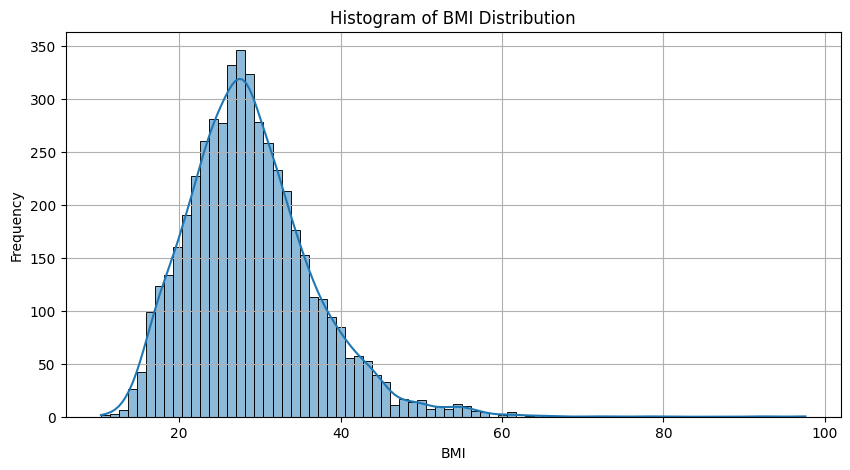

In [7]:
# Plot a histogram of the 'bmi' column
plt.figure(figsize=(10, 5))
sns.histplot(data['bmi'], kde=True)
plt.title('Histogram of BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

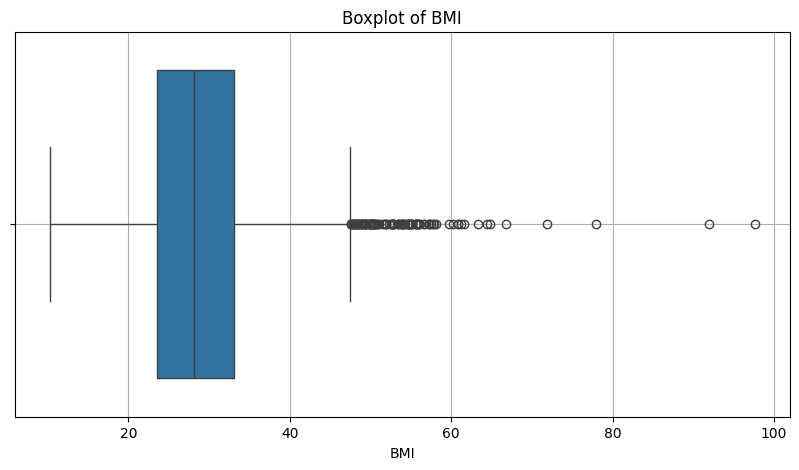

In [11]:
# Visualize outliers and distribution shape with a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['bmi'])
plt.title('Boxplot of BMI')
plt.xlabel('BMI')
plt.grid(True)
plt.show()

In [17]:
from scipy.stats import skew, kurtosis, shapiro

bmi_values = data['bmi'].dropna()  # Removing missing values for accurate statistics

# Calculate skewness and kurtosis
bmi_skewness = skew(bmi_values)
bmi_kurtosis = kurtosis(bmi_values)

# Perform the Shapiro-Wilk test for normality
shapiro_test = shapiro(bmi_values)

print(f"Skewness: {bmi_skewness}")
print(f"Kurtosis: {bmi_kurtosis}")
print("Shapiro-Wilk test statistic:", shapiro_test.statistic, "p-value:", shapiro_test.pvalue)

Skewness: 1.0550177068872404
Kurtosis: 3.3580131522730943
Shapiro-Wilk test statistic: 0.9535468320743545 p-value: 6.615876600227794e-37


A skewness of 1.055 indicates that the distribution of 'bmi' has a tail extending to the right. A kurtosis value of 3.36 (compared to a normal distribution's value of 3) indicates that the distribution has heavier tails and a sharper peak than a normal distribution. Finally, the Shapiro-Wilk test returning a p-value of almost zero indicates that we should reject the null hypothesis that the distribution is normal. In conclusion, there is little doubt that the 'bmi' distribution is skewed, and as such, we should use the **median** to impute its missing values.

In [20]:
# Impute the missing values of 'bmi' with the median of the column
bmi_median = data_svc['bmi'].median()
data_svc.fillna({'bmi': bmi_median}, inplace=True)
data_svc.head()

Next, since SVC works with numerical data, we need to convert the categorical features to numbers. 

k-nearest neighbors classifier